# Time-Stealed, or how social medias are stealing our lives

"Year 2025, a great portion of our lives is experienced within a virtual environment where we can access an infinite stream of information that excites our brain and that pleasures it with rivers of dopamine. The speed, the bright colors, the catchy audios and the enraging news, everything has been carefully engineered to keep us trapped in front of a glowy screen"

Told like this it might sound like the incipit of a cyberpunk novel, but it's actually not that far from our reality, is it? The virtual environments I'm talking about are obviously social medias, that despite all they've done for the free circulation of information, they have a scary dark side.

The aim of this project is to shed a light on that side and investigate where does our time go and why it seems so difficult to put a stop to a now far too common habbit: doomscrolling.

But why should social medias be implemented to keep us on their platforms? To understand this, it's important to clarify what is their business model. Social medias' profit originates primarely from the "attention economy", in other words, they make money by showing tertiary companies' adds to their user base (and by selling their data, but that is a whole other story). So, when the content you're consuming is suddently interrupted by an add, the attention economy has completed its circle: a company made its attempt to convince you to buy their product and the hosting platform made its share. The follow-up question is then, how does the social media of the situation boosts its revenue? Simple, it tries to maximise the exposure time and the engagement of the user. And how does it do it? With a plethora of sophisticated [psychological tricks](https://www.youtube.com/watch?v=uaaC57tcci0) that hook the user's attention for [hours](https://www.statista.com/statistics/433871/daily-social-media-usage-worldwide/) on end.

## 1. The dataset
This project leverages bayesian networks to extract interesting patterns from the dataset [Dark Side Of Social Media](https://www.kaggle.com/datasets/muhammadroshaanriaz/time-wasters-on-social-media?resource=download). This dataset has been generated via synthetic data generation tecniques to simulate real-world social media usage patterns (read the [EDA](https://www.kaggle.com/code/waqi786/in-depth-analysis-of-time-wasters-on-social-media) for further details).

In [62]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.estimators import PC

In [63]:
def visualize_model(model):
    plt.figure(figsize=(12, 7))
    nx.draw_circular(model, node_color='b', node_size=5000, with_labels=True, font_color='w', font_size=9)
    plt.show()

In [64]:
# Loads and previews the dataset and its shape
data = pd.read_csv('Time-Wasters on Social Media.csv', delimiter=',')
print(f'Shape: {data.shape}')
data.head()

Shape: (1000, 31)


,UserID,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,...,ProductivityLoss,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Self Control,Addiction Level,CurrentActivity,ConnectionType
0,1,56,Male,Pakistan,82812,True,True,Engineer,Rural,Instagram,...,3,7,Procrastination,Smartphone,Android,9:00 PM,5,5,Commuting,Mobile Data
1,2,46,Female,Mexico,27999,False,True,Artist,Urban,Instagram,...,5,5,Habit,Computer,Android,5:00 PM,7,3,At school,Wi-Fi
2,3,32,Female,United States,42436,False,True,Engineer,Rural,Facebook,...,6,4,Entertainment,Tablet,Android,2:00 PM,8,2,At home,Mobile Data
3,4,60,Male,Barzil,62963,True,False,Waiting staff,Rural,YouTube,...,3,7,Habit,Smartphone,Android,9:00 PM,5,5,Commuting,Mobile Data
4,5,25,Male,Pakistan,22096,False,True,Manager,Urban,TikTok,...,8,2,Boredom,Smartphone,iOS,8:00 AM,10,0,At home,Mobile Data


## 2. The bayesian network

### 2.1 The variables
The dataset contains many variables spanning from the characteristics of the users to the features of their device. However, for the purpose of this project - which focuses on the time spent on social medias due to their addictive traits - only 8 out of 31 columns have been selected. Here is a brief descriprion of them:

- Reason: the reason why the users entered the platform. It's interesting because it represents the initial emotional state of the users and what they wish to get out of their social media consumption

- Platform: the social media platform used by the users. It's interesting because each platform has its unique features and implementation

- Importance: the importance assigned by the users to the content. It's interesting because it returns relevant information about the cost/benefit tradeoff accepted by the users

- Intentionality: the level of intentionality of the users when they decided to enter the platform. Originally called "self_control", it's interesting because it's one of the behavioural traits that the study wishes to capture

- Engagement: the engagement level of the users with the content. It's interesting because it quantifies the degree of activity/passivity of the content consumption experience

- Context-Switch: how quickly the users switch from one piece of content to the next. Originally called "Scroll-Rate", it's interesting because it tells about the width of the users' attention span

- Time: the total amount of time that the users have spent on the platform. It's the most interesting aspect of the study given that it's the "price" of social media consumption

- Satisfaction: the satisfaction level of the users at the end of the content consumption. It's interesting because it returns relevant information about the cost/benefit tradeoff accepted by the users

In [65]:
# Selects only relevant columns and renames them for clarity
selected_data = data[['Watch Reason', 'Platform', 'Importance Score', 'Self Control', 'Engagement', 'Scroll Rate', 'Total Time Spent', 'Satisfaction']]
selected_data.columns = ['Reason', 'Platform', 'Importance', 'Intentionality', 'Engagement', 'Context-Switch', 'Time', 'Satisfaction']
selected_data.index = data.UserID.values
selected_data.head()

,Reason,Platform,Importance,Intentionality,Engagement,Context-Switch,Time,Satisfaction
1,Procrastination,Instagram,5,5,7867,87,80,7
2,Habit,Instagram,6,7,5944,46,228,5
3,Entertainment,Facebook,3,8,8674,88,30,4
4,Habit,YouTube,2,5,2477,93,101,7
5,Boredom,TikTok,7,10,3093,4,136,2


### 2.2 The structures
Bayesian Networks can be build in different ways.

#### 2.3.1 The standard model
This Bayesian Network has been build by applying the PC algorithm. This algorithm inserts variables one by one and, at each step, adds a link between the new variable and the old ones only if they are conditionally dependent. A is conditionally dependent to B when:

$$P(A|B) \neq P(A)P(B)$$

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Reason': 'C', 'Platform': 'C', 'Importance': 'N', 'Intentionality': 'N', 'Engagement': 'N', 'Context-Switch': 'N', 'Time': 'N', 'Satisfaction': 'N'}
Working for n conditional variables: 2:  40%|████      | 2/5 [00:09<00:14,  4.96s/it]


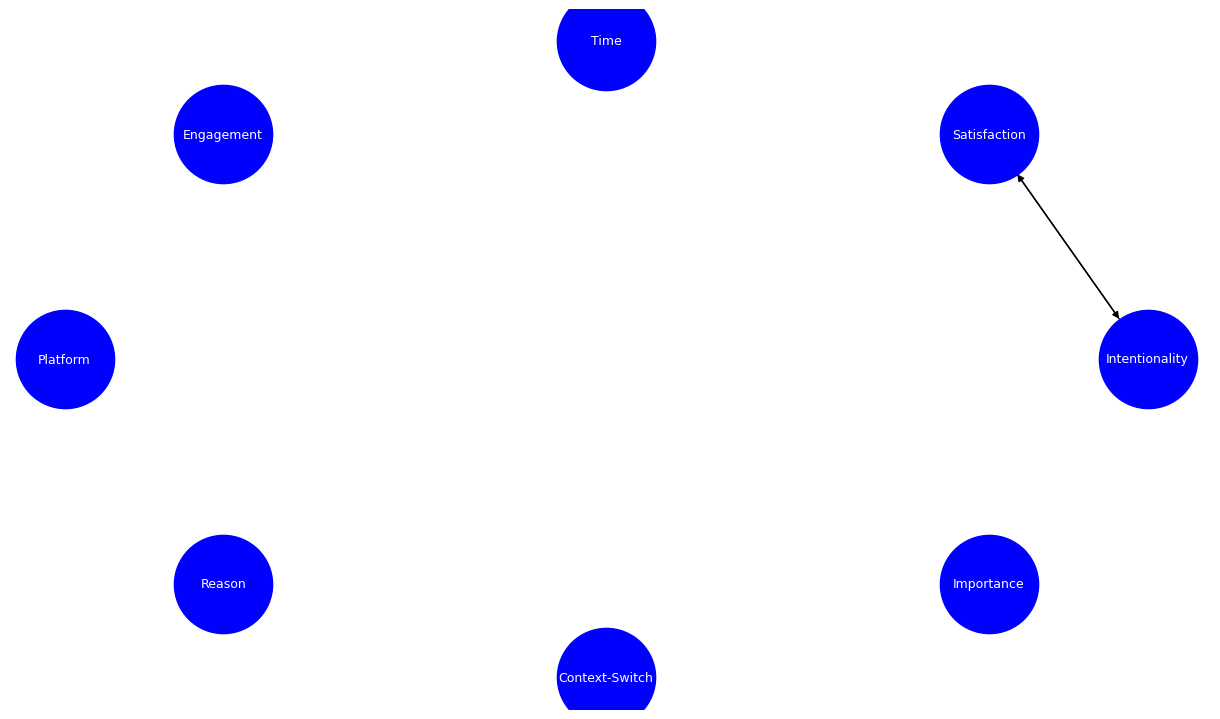

In [66]:
pc_estimator = PC(selected_data)
pc_model = pc_estimator.estimate()
visualize_model(pc_model)

#### 2.3.2 The custom model
This Bayesian Network has been build by adding variables one by one following this order:

Reason -> Platform -> Importance -> Intentionality -> Engagement -> Context-Switch -> Time -> Satisfaction

This is because users choose the platform according to the reason that motivates them to enter the social media space. Depending on the importance of their session, they are more or less intentional with their consumption which effects their engagement and their context-switch. All the previous variables impact the time spent on the platform and the satisfaction associated to the experience.

At each step, a link between the new variable and the old ones is added according to these considerations:

- Addition of Reason
- Addition of Platform
    - Reason -> Platform: the platform chosen for the session depends on the reason that initiated it as different platforms might be chosen for different reasons
- Addition of Importance
    - Reason -> Importance: the importance of the session depends on the reason that initiated it, for ex: the educational purpose might be considered more important that the procrastination one
- Addition of Intentionality
    - Reason -> Intentionality: the intentionality of the session depends on the reason that initiated it, for ex: if the session started as a habit, then the intentionality might be low, whereas if it started to communicate with someone, then it might be high
    - Platform -> Intentionality: the intentionality of the session depends on the platform as certain platforms are more addictive than others
- Addition of Engagement
    - Reason -> Engagement: the engagement of the session depends on the reason that initiated it, for ex: if the session started for boredom, then the engagement might be low, whereas if it started for entertainment, then it might be high
- Addition of Context-Switch
    - Platform -> Context-Switch: the context-switch level of the session depends on the chosen platform as certain platforms host short pieces of content while others longer ones
    - Engagement -> Context-Switch: the context-switch level of the session depends on the engagement because the more the users are engaged with a certain piece of content the less they context-switch, and vice-versa
- Addition of Time
    - Intentionality -> Time: the time spent on the platform depends on the intentionality as an intentional session might be more efficient than an unintentional one
- Addition of Satisfaction
    - Importance -> Satisfaction, Time -> Satisfaction: the satisfaction associated to the session depends on the ratio between its importance and its duration

In [67]:
# Defines the BN
custom_model = DiscreteBayesianNetwork([
    ('Reason', 'Platform'),
    ('Reason', 'Importance'),
    ('Reason', 'Intentionality'),
    ('Reason', 'Engagement'),
    ('Platform', 'Intentionality'),
    ('Platform', 'Context-Switch'),
    ('Importance', 'Satisfaction'),
    ('Intentionality', 'Time'),
    ('Engagement', 'Context-Switch'),
    ('Time', 'Satisfaction')
])

# Fits the data into the BN to learn the CPTs (a CPT is a table that specifies the probability of each value of a variable for every combination of values of its parents)
custom_model.cpds = []
custom_model.fit(selected_data)

# Prints the CPTs
for cpd in custom_model.get_cpds():
    print('CPT of {}'.format(cpd.variable))
    print(cpd, '\n')

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Reason': 'C', 'Platform': 'C', 'Importance': 'N', 'Intentionality': 'N', 'Engagement': 'N', 'Context-Switch': 'N', 'Time': 'N', 'Satisfaction': 'N'}


CPT of Reason
+-------------------------+-------+
| Reason(Boredom)         | 0.277 |
+-------------------------+-------+
| Reason(Entertainment)   | 0.264 |
+-------------------------+-------+
| Reason(Habit)           | 0.339 |
+-------------------------+-------+
| Reason(Procrastination) | 0.12  |
+-------------------------+-------+ 

CPT of Platform
+---------------------+-----+-------------------------+
| Reason              | ... | Reason(Procrastination) |
+---------------------+-----+-------------------------+
| Platform(Facebook)  | ... | 0.25                    |
+---------------------+-----+-------------------------+
| Platform(Instagram) | ... | 0.2916666666666667      |
+---------------------+-----+-------------------------+
| Platform(TikTok)    | ... | 0.21666666666666667     |
+---------------------+-----+-------------------------+
| Platform(YouTube)   | ... | 0.24166666666666667     |
+---------------------+-----+-------------------------+ 

CPT of Importance
+-------

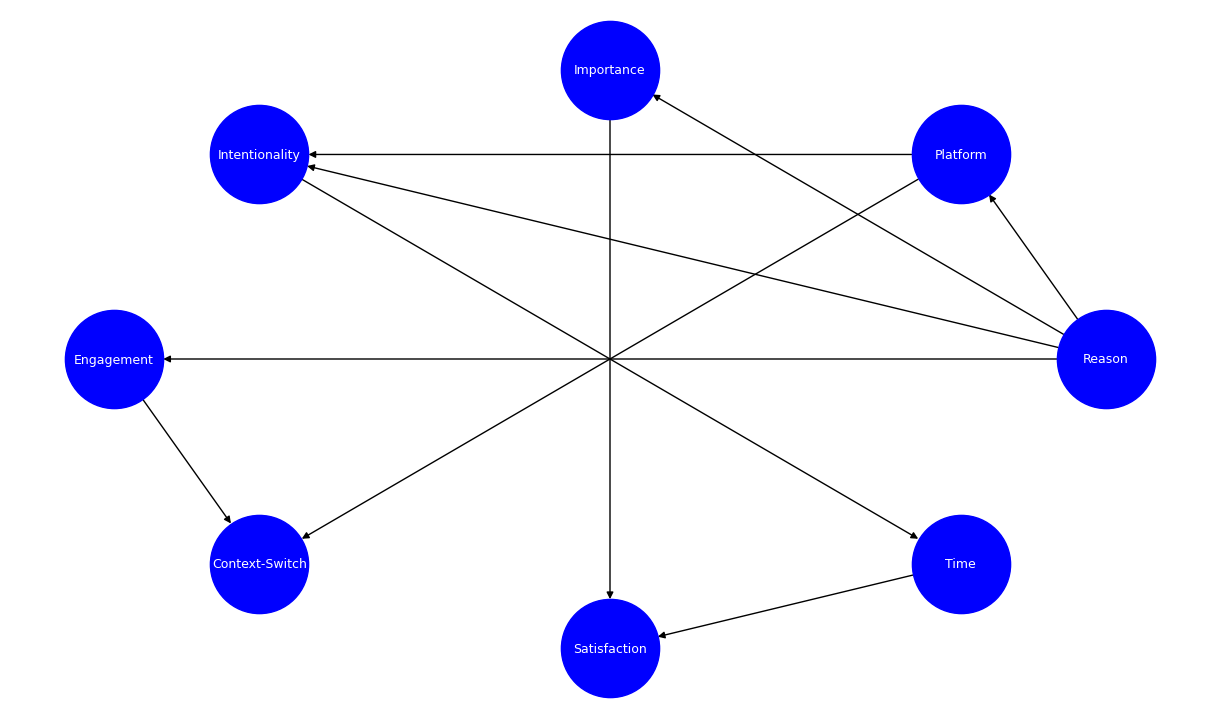

In [68]:
# Visualises the BN
visualize_model(custom_model)

$$P(R,P,Im,In,E,C,T,S) = P(R)P(P|R)P(Im|R)P(In|R,P)P(E|R)P(C|P,E)P(T|In)P(S|Im,T)

## 3. The inferences

The inferences will investigate low/high levels of *place_holder*, so it is necessary to define some thresholds:

- Important session: > 5 (assuming the scale is 1-10)
- High intentionality: > 5 (assuming the scale is 1-10)
- High engagement: > 500 (assuming the scale is 1-1000)
- High context-switch: > 50 (assuming the scale is 1-100)
- Long session: > 30 (assuming min as the unit of measurement)
- High satisfaction: > 5 (assuming the scale is 1-10)

Assumptions on scales and units of measurement are necessary as the dataset description lacks the needed details. However, it was possible to extract the following information about the domains of the variables:

In [69]:
# Prints the domain of each variable:
for c in selected_data.columns:
    domain = selected_data[c].unique()
    if domain.dtype == "int64":
        print(f"Domain of {c}: [min: {domain.min()}, max: {domain.max()}]")
    else:
        print(f"Domain of {c}: {domain}")

Domain of Reason: ['Procrastination' 'Habit' 'Entertainment' 'Boredom']
Domain of Platform: ['Instagram' 'Facebook' 'YouTube' 'TikTok']
Domain of Importance: [min: 1, max: 9]
Domain of Intentionality: [min: 3, max: 10]
Domain of Engagement: [min: 15, max: 9982]
Domain of Context-Switch: [min: 1, max: 99]
Domain of Time: [min: 10, max: 298]
Domain of Satisfaction: [min: 1, max: 9]


In [70]:
variable_eliminator = VariableElimination(custom_model)

long_time_states = [s for s in custom_model.states['Time'] if s > 30]
low_intentionality_states = [s for s in custom_model.states['Intentionality'] if s <= 5]
low_satisfaction_states = [s for s in custom_model.states['Satisfaction'] if s <= 5]

### 3.1 What is the probability that a shallow session is long?

In [71]:
# P(T>30,In<=5)
p_d_of_t_and_in = variable_eliminator.query(variables=['Time', 'Intentionality'], joint=True)
p_of_long_t_and_low_in = 0
for t in long_time_states:
    for i in low_intentionality_states:
        p_of_long_t_and_low_in += p_d_of_t_and_in.get_value(**{'Time':t, 'Intentionality':i})
print(f"P(T>30,In<=5): {p_of_long_t_and_low_in}")

# P(In<=5)
p_d_of_in = variable_eliminator.query(variables=['Intentionality'])
p_of_low_in = 0
for i in low_intentionality_states:
    p_of_low_in += p_d_of_in.get_value(**{'Intentionality':i})
print(f"P(In<=5): {p_of_low_in}")

# P(T>30|T<=5) = P(T>30,In<=5) / P(In<=5)
p_of_long_t_given_low_in = p_of_long_t_and_low_in / p_of_low_in
print(f"P(T>30|In<=5): {p_of_long_t_given_low_in}")

P(T>30,In<=5): 0.2990000000000002
P(In<=5): 0.31700000000000006
P(T>30|In<=5): 0.9432176656151424


### 3.2 What is the probability that a long session is not satisfying?

In [72]:
# P(S<=5,T>30)
p_d_of_s_and_t = variable_eliminator.query(variables=['Satisfaction', 'Time'], joint=True)
p_of_low_s_and_long_t = 0
for s in low_satisfaction_states:
    for t in long_time_states:
        p_of_low_s_and_long_t += p_d_of_s_and_t.get_value(**{'Satisfaction':s, 'Time':t})
print(f"P(S<=5,T>30): {p_of_low_s_and_long_t}")

# P(T>30)
p_d_of_t = variable_eliminator.query(variables=['Time'])
p_of_long_t = 0
for t in long_time_states:
    p_of_long_t += p_d_of_t.get_value(**{'Time':t})
print(f"P(T>30): {p_of_long_t}")

# P(S<=5|T>30) = P(S<=5,T>30) / P(T>30)
p_of_low_s_given_long_t = p_of_low_s_and_long_t / p_of_long_t
print(f"P(S<=5|T>30): {p_of_low_s_given_long_t}")

P(S<=5,T>30): 0.5412071284395471
P(T>30): 0.9200000000000007
P(S<=5|T>30): 0.5882686178690725


### 3.3 What is the probability that a long and shallow session is not satisfying?

In [73]:
# P(S<=5,T>30,In<=5)
p_d_of_s_and_t_and_in = variable_eliminator.query(variables=['Satisfaction', 'Time', 'Intentionality'], joint=True)
p_of_low_s_and_long_t_and_low_in = 0
for s in low_satisfaction_states:
    for t in long_time_states:
        for i in low_intentionality_states:
            p_of_low_s_and_long_t_and_low_in += p_d_of_s_and_t_and_in.get_value(**{'Satisfaction':s, 'Time':t, 'Intentionality':i})
print(f"P(S<=5,T>30,In<=5): {p_of_low_s_and_long_t_and_low_in}")

# P(S<=5|T>30,In<=5) = P(S<=5,T>30,In<=5) / P(T>30,In<=5)
p_of_low_s_given_long_t_and_low_in = p_of_low_s_and_long_t_and_low_in / p_of_long_t_and_low_in
print(f"P(S<=5|T>30,In<=5): {p_of_low_s_given_long_t_and_low_in}")

P(S<=5,T>30,In<=5): 0.15697194336818762
P(S<=5|T>30,In<=5): 0.5249897771511288


### 3.4 What is the probability that a shallow session is not satisfying?

In [74]:
# P(S<=5,In<=5)
p_d_of_s_and_in = variable_eliminator.query(variables=['Satisfaction', 'Intentionality'], joint=True)
p_of_low_s_and_low_in = 0
for s in low_satisfaction_states:
    for i in low_intentionality_states:
        p_of_low_s_and_low_in += p_d_of_s_and_in.get_value(**{'Satisfaction':s, 'Intentionality':i})
print(f"P(S<=5,In<=5): {p_of_low_s_and_low_in}")

# P(S<=5|In<=5) = P(S<=5,In<=5) / P(In<=5)
p_of_low_s_given_low_in = p_of_low_s_and_low_in / p_of_low_in
print(f"P(S<=5|In<=5): {p_of_low_s_given_low_in}")

P(S<=5,In<=5): 0.1671658189149361
P(S<=5|In<=5): 0.5273369681859181


## 4. The conclusions